In [ ]:
#READING CSV
import pandas as pd
from copy import deepcopy
import math

almacenes = pd.read_csv("https://raw.githubusercontent.com/billguerrerog/cc41_tf_201821590_20181B402_201811208_201823346_201823838/main/almacenes.csv")
alm = almacenes[['Coord X', 'Coord Y']]
nodeTypeALM = [1]*100
alm['NodeType'] = nodeTypeALM

puntos_entrega = pd.read_csv("https://raw.githubusercontent.com/billguerrerog/cc41_tf_201821590_20181B402_201811208_201823346_201823838/main/puntos_entrega.csv")
pe = puntos_entrega[['Coord X', 'Coord Y']]
nodeTypePE = [2]*5000
pe['NodeType'] = nodeTypePE

In [ ]:
#Join both lists
newDF = pd.concat([alm, pe])

#List to use (nodeType) and list to compare (noType)
nodeTypeList = newDF[['Coord X', 'Coord Y', 'NodeType']].values.tolist()
noTypeList = newDF[['Coord X', 'Coord Y']].values.tolist()

In [ ]:
#Sorting List by Y then by X
def orderList(list_):
    newL = sorted(list_, key=lambda y: y[1])
    newL.sort(key=lambda x: x[0])
    return deepcopy(newL)

newL = orderList(noTypeList)
newTypeList = orderList(nodeTypeList)

In [ ]:
# Storage/DeliveryPoint Nodes to append
def popStuff(popList, times):
    to_return = []
    popList.reverse()
    for j in range(times):
        to_return.append(popList.pop())
    popList.reverse()
    return to_return

#Search X Coords Nodes (it's sorted already)
def searchX(tempList, tempNodeTypeList, x):
    returnList = []
    popped = []
    max = 0

    if len(tempList)==0 and len(tempNodeTypeList)==0:
        return returnList, popped
    for i in tempList: #Getting comparison list
        if i[0] == x:
            max += 1
            returnList.append(i)
        else:
            break
    
    popStuff(tempList, max)
    popped = []
    popped = popStuff(tempNodeTypeList, max)
    return returnList, popped

In [ ]:
# Create graph
def graph(nodesList, newL_, newTypeList_):
    xList = [i for i in range(1000)]
    yList = [i for i in range(1000)]
    nodesCont = 0

    tempNoTypeList = deepcopy(newL_)
    tempTypeList = deepcopy(newTypeList_)

    for x in xList:
        smallList = [] #Comparison list
        popped = [] #To List
        if len(tempNoTypeList)>0 and len(tempTypeList)>0:
            smallList, popped = searchX(tempNoTypeList, tempTypeList, x)
        for y in yList:
            ady1 = nodesCont - 1000 #left then goes clockwise
            ady2 = nodesCont - 1
            ady3 = nodesCont + 1000
            ady4 = nodesCont + 1
            # Validations - not corners
            if x == 0: ady1 = -1
            if x == 999: ady3 = -1
            if y == 0: ady2 = -1
            if y == 999: ady4 = -1

            ady0 = [ady1, ady2, ady3, ady4]

            if len(popped) > 0 and len(smallList) > 0 and [x, y] in smallList:
                t = popped.pop(0)
                nodesList.append([t[0], t[1], t[2], ady0])
            else:
                nodesList.append([x, y, 0, ady0])
            
            nodesCont += 1

In [ ]:
# Creating the new graph
nodes = []
graph(nodes, newL, newTypeList)

In [ ]:
# Making a copy of resulting graph
nodes_copy = deepcopy(nodes)

In [ ]:
#Methods to show graph
def popStuffAndDelete(popList, times):
    to_return = []
    popList.reverse()
    for j in range(times):
        popped = popList.pop()
        del popped[3]
        del popped[2]
        to_return.append(popped)
    popList.reverse()
    return to_return

def deleteStuff(nodesList):
    for i in nodesList:
        del i[3]
        del i[2]

def separateTypes(tempNodes, x):
    max = 0
    for i in tempNodes:
        if i[2] == x:
            max += 1
        else:
            popped = popStuffAndDelete(tempNodes, max)
            return popped

In [ ]:
#Copies to show graph
new_nodes = sorted(nodes_copy, key=lambda y: y[2])
new_nodes_copy = deepcopy(new_nodes)

normal_nodes = separateTypes(new_nodes_copy, 0)
alm_nodes = separateTypes(new_nodes_copy, 1)
ent_nodes = new_nodes_copy
deleteStuff(ent_nodes)

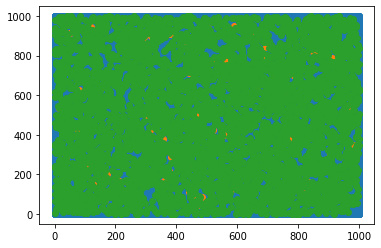

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Show graph
normal_np = np.array(normal_nodes)
alm_np = np.array(alm_nodes)
ent_np = np.array(ent_nodes)

plt.scatter(*zip(*normal_np))
plt.scatter(*zip(*alm_np))
plt.scatter(*zip(*ent_np))

cm = 1/2.54
plt.rcParams["figure.figsize"] = [60*cm, 30*cm]
plt.rcParams["figure.autolayout"] = True
plt.show()

In [17]:
# Making a copy of resulting graph
nodes_copy = deepcopy(nodes)

In [18]:
# BFS since all edges have the same weight (from a node)
def bfs(graph, s, size):
    visited = [False]*size
    parent = [None]*size
    queue = [s]
    visited[s] = True

    while queue:
        u = queue.pop(0)
        node = graph[u]
        for v in node[3]:
            if v >= 0:
                if not visited[v]:
                    visited[v] = True
                    parent[v] = u
                    queue.append(v)

    return parent

def find_route(all_routes, alm_node, ent_node):
    start_node = all_routes[ent_node] #returns parent
    #ir desde ent_node hasta alm_node con un while, hasta que encuentre el nodo que necesita
    #Las rutas se obtienen recorriendo las rutas generales de manera inversa
    route = []
    route.append(ent_node)

    if start_node == alm_node: #Comprueba si son nodos adyacentes
        route.append(alm_node)
        route.reverse()
        return route

    while start_node != alm_node: #Recorre los padres desde el punto de entrega hasta el almacén (inversamente)
        route.append(start_node)
        start_node = all_routes[start_node]

    route.append(alm_node)
    route.reverse()
    return route #returns 1 route

def get_coords(i):
    z = 1000
    x = i//z
    y = i % z
    return x, y

def get_node(x, y):
    return (x*1000) + y

def get_distance(alm_node, ent_node):
    alm_x, alm_y = get_coords(alm_node)
    ent_x, ent_y = get_coords(ent_node)
    return math.sqrt((ent_x - alm_x)**2 + (ent_y - alm_y)**2)

def find_nodes(graph, node_type, max):
    nodes = []
    cont_ent = 0
    size = len(graph)
    for i in range(size):
        if graph[i][2] == node_type:
            nodes.append(i)
            cont_ent += 1
        if cont_ent == max:
            return nodes #returns all nodes of that type

In [19]:
def find_shorter_route(graph, alm_node, size, ent_nodes_list, routes, shortest_routes):
    parent = bfs(graph, alm_node, size)

    for i in range(len(ent_nodes_list)): #ent_nodes
        route = []
        route.append(alm_node)
        route.append(ent_nodes_list[i])
        #check_route = find_route(parent, alm_node, ent_nodes_list[i])
        check_distance = get_distance(alm_node, ent_nodes_list[i]) #Closest to Storage Point
        if len(shortest_routes) < len(ent_nodes_list): # Empty list
            routes.append(route)
            shortest_routes.append(check_distance)
        else:
            #if len(check_route) < len(shortest_routes[i]): #Check if it's a shorter route
            if check_distance < shortest_routes[i]:
                routes[i] = route
                shortest_routes[i] = check_distance # Replace if so

def pop_asigned_delivery(ordered_list, storage_point):
    delivery_points = []
    for j in range(len(ordered_list)):
        if ordered_list[-1][0] == storage_point:
            aux = ordered_list.pop()
            delivery_points.append(aux[1])
            if len(ordered_list) == 0:
                return delivery_points
        else:
            return delivery_points

def shortest_routes(graph, size): #Only asking to every Storage node
    routes = []
    shortest_routes = []
    cont_alm = 0
    alm_nodes_list = find_nodes(graph, 1, 100) #alm = 1 / ent = 2
    ent_nodes_list = find_nodes(graph, 2, 5000) #alm = 1 / ent = 2

    for i in range(len(alm_nodes_list)):
        find_shorter_route(graph, alm_nodes_list[i], size, ent_nodes_list, routes, shortest_routes)

    #Order by Storage Point
    ordered_by_alm = sorted(routes, key=lambda a: a[0], reverse=True)
    by_alm = []
    for i in alm_nodes_list:
        asigned_delivery_points = []
        asigned_delivery_points = pop_asigned_delivery(ordered_by_alm, i)
        aux = []
        aux.append(i)
        aux.append(asigned_delivery_points)
        by_alm.append(aux)

    return by_alm #5k routes

In [20]:
#Takes 3 mins
asigned_delivery_points = shortest_routes(nodes_copy, len(nodes_copy))

In [ ]:
for i in range(100):
    print(asigned_delivery_points[i])

In [22]:
#Get single region
def get_region(alm, asigned_delivery):
    min_x, min_y = get_coords(alm) # Start
    max_x, max_y = get_coords(alm) # Start
    for i in asigned_delivery: #Getting min and max coords to create region
        delivery_x, delivery_y = get_coords(i) #Coords to compare
        if delivery_x < min_x: #Check min X
            min_x = delivery_x
        elif delivery_x > max_x: #Check max X
            max_x = delivery_x
        if delivery_y < min_y: #Check min Y
            min_y = delivery_y
        elif delivery_y > max_y: #Check max Y
            max_y = delivery_y

    min_max = [min_x, min_y, max_x, max_y]
    return min_max

# Get Regions
def all_regions(asigned_stuff):
    regions = []
    for i in asigned_stuff:
        aux = []
        region = get_region(i[0], i[1])
        aux.append(i[0])
        aux.append(region) #Region coords
        regions.append(aux)
    
    return regions

In [23]:
regions = all_regions(asigned_delivery_points)

In [44]:
import heapq as hq

def adjacencies(region): #Create region adjacencies
    xList = [i for i in range(region[0], region[2] + 1)]
    yList = [i for i in range(region[1], region[3] + 1)]

    nodes_region = {}

    for x in xList:
        for y in yList:
            nodes_region[get_node(x, y)] = []
    
    for node in nodes_region:
            ady1 = node - 1000 #left then goes clockwise
            ady2 = node - 1
            ady3 = node + 1000
            ady4 = node + 1
            # Validations - not corners
            if x == 0: ady1 = -1
            if x == 999: ady3 = -1
            if y == 0: ady2 = -1
            if y == 999: ady4 = -1

            ady0 = [ady1, ady2, ady3, ady4]
            for i in ady0:
                if i in nodes_region:
                    nodes_region[node].append(i)
    
    return nodes_region

def new_dijkstra(graph, start):
    visited = {}
    parent = {}
    cost = {}
    queue = [(start, 0)]
    visited[start] = True
    for i in graph:
        visited[i] = False
        parent[i] = None
        cost[i] = math.inf
    
    cost[start] = 0

    while queue:
        u, g_u = hq.heappop(queue)
        if not visited[u]:
            visited[u] = True
            for v in graph[u]:
                f = g_u + 1 #No cost
                if f < cost[v]:
                    cost[v] = f
                    parent[v] = u
                    hq.heappush(queue, (v, f))

    return parent

def all_regions(regions):
    routes = []
    regions_adj = []

    for i in range(len(regions)):
        alm, region = regions[i]
        nodes = adjacencies(region)

        route = new_dijkstra(nodes, alm)
        routes.append(route)
        
        regions_adj.append(nodes)

    return routes, regions_adj

In [45]:
routes, regions_adj = all_regions(regions)

In [58]:
for i in range(1):
    print(routes[i])
print(len(routes))

{1461: 1462, 1462: 1463, 1463: 1464, 1464: 1465, 1465: 1466, 1466: 1467, 1467: 1468, 1468: 1469, 1469: 1470, 1470: 1471, 1471: 1472, 1472: 1473, 1473: 1474, 1474: 1475, 1475: 1476, 1476: 1477, 1477: 1478, 1478: 1479, 1479: 1480, 1480: 1481, 1481: 1482, 1482: 1483, 1483: 1484, 1484: 1485, 1485: 1486, 1486: 1487, 1487: 1488, 1488: 1489, 1489: 1490, 1490: 1491, 1491: 1492, 1492: 1493, 1493: 1494, 1494: 1495, 1495: 1496, 1496: 1497, 1497: 1498, 1498: 1499, 1499: 1500, 1500: 1501, 1501: 1502, 1502: 1503, 1503: 1504, 1504: 1505, 1505: 1506, 1506: 1507, 1507: 1508, 1508: 1509, 1509: 1510, 1510: 1511, 1511: 1512, 1512: 1513, 1513: 1514, 1514: 1515, 1515: 1516, 1516: 1517, 1517: 1518, 1518: 1519, 1519: 1520, 1520: 1521, 1521: 1522, 1522: 1523, 1523: 1524, 1524: 1525, 1525: 1526, 1526: 1527, 1527: 1528, 1528: 1529, 1529: 1530, 1530: 1531, 1531: 1532, 1532: 1533, 1533: 1534, 1534: 1535, 1535: 2535, 1536: 1535, 1537: 1536, 1538: 1537, 1539: 1538, 1540: 1539, 1541: 1540, 1542: 1541, 1543: 1542, 154

In [ ]:
for i in range(20):
    print(regions[i])

print(len(regions))

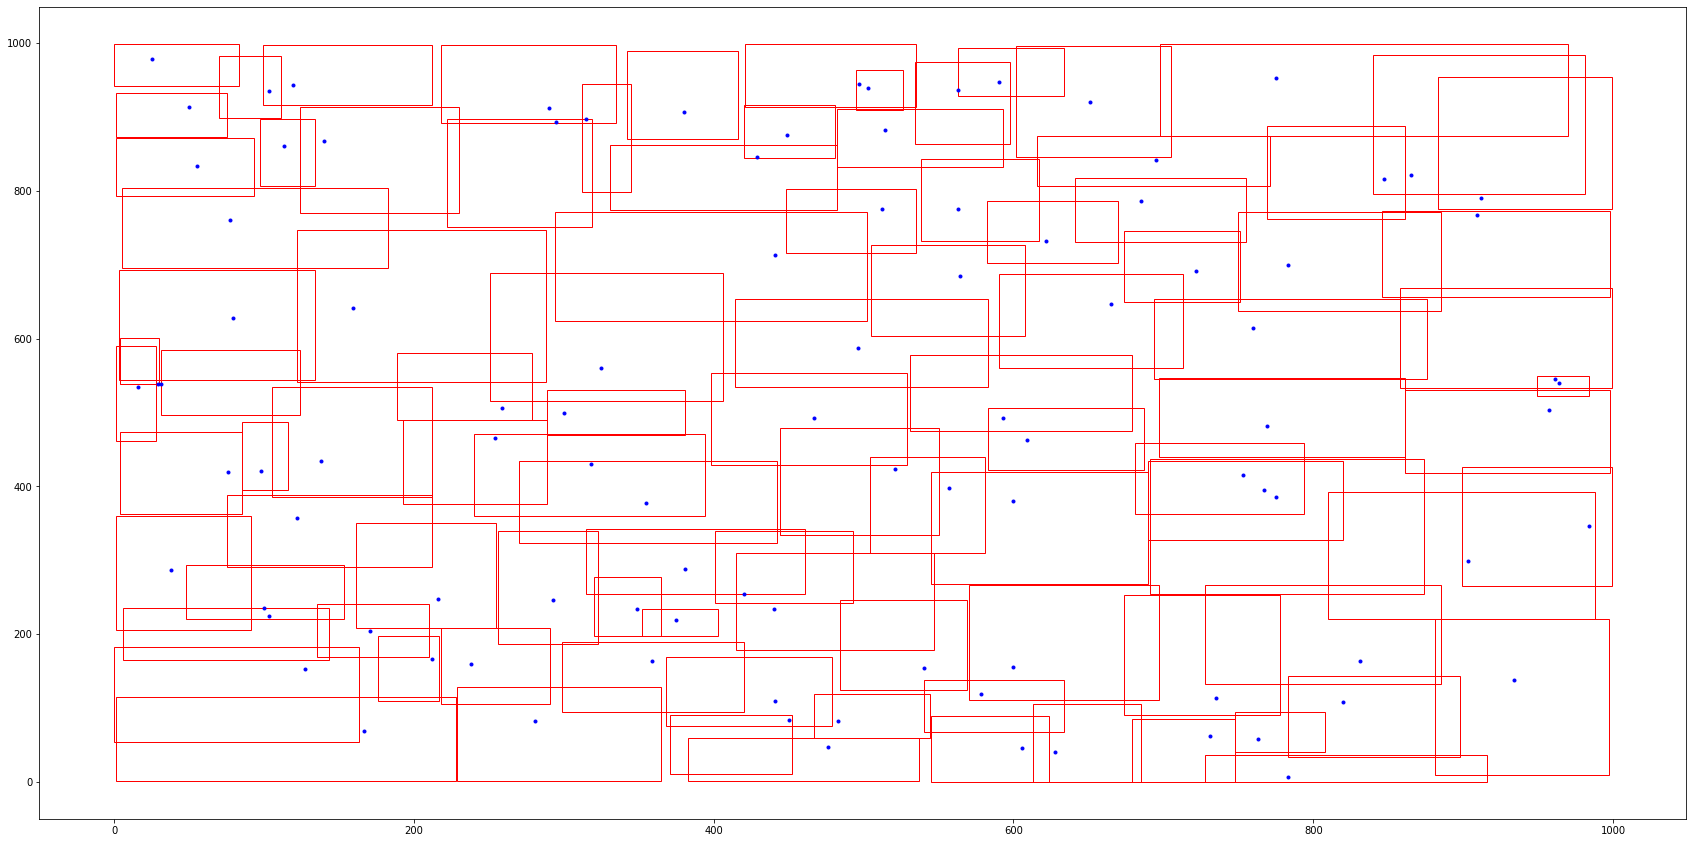

In [48]:
import matplotlib.patches as patches

fig, ax = plt.subplots()

for i in range(100):
    clr = 'red'
    min_x = regions[i][1][0]
    min_y = regions[i][1][1]
    max_x = regions[i][1][2]
    max_y = regions[i][1][3]
    rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    cm = 1/2.54
    plt.rcParams["figure.figsize"] = [60*cm, 30*cm]
    alm_x, alm_y = get_coords(regions[i][0])
    plt.plot(alm_x, alm_y, '.', color='blue')
    plt.rcParams["figure.autolayout"] = True
    plt.plot

plt.show()

In [49]:
def get_my_region(all_regions, member_number):
    regions_size = int(len(all_regions)/5)
    min = member_number*regions_size
    max = (member_number + 1)*regions_size
    member_regions = []
    for i in range(min, max):
        member_regions.append(all_regions[i])

    return member_regions

In [62]:
# ALGORITMO 1 - Bill Guerrero González - u201821590

# Not working yet
# def find_route_1(my_regions):
#     routes, regions_adj = all_regions(my_regions)


#     start_node = all_routes[ent_node] #returns parent
#     #ir desde ent_node hasta alm_node con un while, hasta que encuentre el nodo que necesita
#     #Las rutas se obtienen recorriendo las rutas generales de manera inversa
#     route = []
#     route.append(ent_node)

#     if start_node == alm_node: #Comprueba si son nodos adyacentes
#         route.append(alm_node)
#         route.reverse()
#         return route

#     while start_node != alm_node: #Recorre los padres desde el punto de entrega hasta el almacén (inversamente)
#         route.append(start_node)
#         start_node = all_routes[start_node]

#     route.append(alm_node)
#     route.reverse()
#     return route #returns 1 route

def algorithm_1(graph, start):
    visited = {}
    parent = {}
    for i in graph:
        visited[i] = False
        parent[i] = None
    
    visited[start] = True
    queue = [start]

    while queue:
        u = queue.pop(0)
        for v in graph[u]:
            if not visited[v]:
                visited[v] = True
                parent[v] = u
                queue.append(v)

    return parent

def my_routes_1(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_1(nodes, alm)
        routes.append(route)

    return routes


my_regions_1 = get_my_region(regions, 0)
my_regions_routes = my_routes_1(my_regions_1)

for i in range(3):
    print(my_regions_routes[i])
print(len(my_regions_routes))

{1461: 1462, 1462: 1463, 1463: 1464, 1464: 1465, 1465: 1466, 1466: 1467, 1467: 1468, 1468: 1469, 1469: 1470, 1470: 1471, 1471: 1472, 1472: 1473, 1473: 1474, 1474: 1475, 1475: 1476, 1476: 1477, 1477: 1478, 1478: 1479, 1479: 1480, 1480: 1481, 1481: 1482, 1482: 1483, 1483: 1484, 1484: 1485, 1485: 1486, 1486: 1487, 1487: 1488, 1488: 1489, 1489: 1490, 1490: 1491, 1491: 1492, 1492: 1493, 1493: 1494, 1494: 1495, 1495: 1496, 1496: 1497, 1497: 1498, 1498: 1499, 1499: 1500, 1500: 1501, 1501: 1502, 1502: 1503, 1503: 1504, 1504: 1505, 1505: 1506, 1506: 1507, 1507: 1508, 1508: 1509, 1509: 1510, 1510: 1511, 1511: 1512, 1512: 1513, 1513: 1514, 1514: 1515, 1515: 1516, 1516: 1517, 1517: 1518, 1518: 1519, 1519: 1520, 1520: 1521, 1521: 1522, 1522: 1523, 1523: 1524, 1524: 1525, 1525: 1526, 1526: 1527, 1527: 1528, 1528: 1529, 1529: 1530, 1530: 1531, 1531: 1532, 1532: 1533, 1533: 1534, 1534: 1535, 1535: 2535, 1536: 1535, 1537: 1536, 1538: 1537, 1539: 1538, 1540: 1539, 1541: 1540, 1542: 1541, 1543: 1542, 154